In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy.stats import itemfreq
import random
import os.path

import theano
import lasagne
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.externals import joblib
from sklearn.svm import SVC

from nolearn.lasagne import visualize

# import user defined load_data to build input data
from load_data import Data
from utils import save_network
from model_predictions import build_cnn
from model_predictions import generate_features
from model_predictions import extract_features

# file path of three directory: data, model and wordvec 
FILE_PATH = '../files/'

### Use Airline data

In [2]:
airline_data = Data('Airline-Sentiment-2-w-AA.csv', FILE_PATH)
airline_df = airline_data.csv_df(['airline_sentiment', 'text']) # load data
airline_data.pre_process(airline_df) # pre-process data
# drop neutral
# airline_df = airline_data.drop_value(airline_df, 'airline_sentiment', 'neutral')
airline_df.head()

Loading csv: Airline-Sentiment-2-w-AA.csv ...
Note: pre-process changes the dataframe inplace.


,airline_sentiment,text,tokenized
0,neutral,What said,[said]
1,positive,plus you ve added commercials to the experie...,"[plus, added, commercials, experience, tacky]"
2,neutral,I didn t today Must mean I need to take a...,"[today, must, mean, need, take, another, trip]"
3,negative,it s really aggressive to blast obnoxious e...,"[really, aggressive, blast, obnoxious, enterta..."
4,negative,and it s a really big bad thing about it,"[really, big, bad, thing]"


In [3]:
# convert categorical value to int class
# class_label = {'positive': 1, 'negative': 2}
class_label = {'positive': 1, 'neutral': 2, 'negative': 3}

airline_df = airline_data.cat2num(airline_df, 'airline_sentiment', class_label, 'class')
airline_df.head()

class
Done converting categorical to numeric, this changes df.


,text,tokenized,class
0,What said,[said],2
1,plus you ve added commercials to the experie...,"[plus, added, commercials, experience, tacky]",1
2,I didn t today Must mean I need to take a...,"[today, must, mean, need, take, another, trip]",2
3,it s really aggressive to blast obnoxious e...,"[really, aggressive, blast, obnoxious, enterta...",3
4,and it s a really big bad thing about it,"[really, big, bad, thing]",3


In [4]:
# lets take a look of the 
airline_df['class'].value_counts()

3    9178
2    3099
1    2363
Name: class, dtype: int64

In [5]:
# comment out if do not want class balance
airline_df = airline_data.balance_class(airline_df)
# and check again
airline_df['class'].value_counts()

3    3099
2    3099
1    2363
Name: class, dtype: int64

In [6]:
airline_df.head()

,text,tokenized,class
0,What said,[said],2
1,plus you ve added commercials to the experie...,"[plus, added, commercials, experience, tacky]",1
2,I didn t today Must mean I need to take a...,"[today, must, mean, need, take, another, trip]",2
3,seriously would pay a flight for seats t...,"[seriously, would, pay, flight, seats, playing...",3
4,yes nearly every time I fly VX this ear ...,"[yes, nearly, every, time, fly, vx, ear, worm,...",1


In [7]:
# train or load the model
model = airline_data.build_wordvec(size=600, verbose=False)

Loading existing model tweets600.model.bin ...
Done building.


In [8]:
# max_len is the max length of a sentence in our data, this decides the padding
max_len = airline_data.max_len(airline_df)
# convert our aline data to vector
data = airline_data.convert2vec(airline_df, max_len, model, name='airline-3class-600')
#data = airline_data.standarize(data)
airline_data.save_vec(data, name='airline-3class-600')

max sentence length is:  21
>>> 0 tweets converted ...
>>> 2000 tweets converted ...
>>> 4000 tweets converted ...
>>> 6000 tweets converted ...
>>> 8000 tweets converted ...
Total 48 not in vocab.
Done converting tweets to vec!
Saved airline-3class-600 to disk.


In [9]:
# you can uncomment this to check if the wordvec makes sense
# model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

### create data that gets fed into classifier

In [10]:
N, M, D = data.shape
print "N, M, D:", N, M, D
data = data.reshape(-1, 1, M, D).astype(theano.config.floatX) # theano needs this way
label = airline_df['class']
label = np.int8(label) - 1# seems like theano also needs this
print data.shape
print label.shape

N, M, D: 8561 21 600
(8561, 1, 21, 600)
(8561,)


In [11]:
# train our model or load model if it exists
def train_cnn(net, X_train, y_train, model_name='nn_cnn1'):
    model_file = FILE_PATH+'model/nn_cnn1'
    if os.path.isfile(model_file):
        print ("Loading existing model ...")
        net.load_params_from(model_file)
    else:
        # Train the network
        net.fit(X_train, y_train)
        net.save_params_to(model_file)

In [12]:
# initialize
cnn= build_cnn(M, D)
# train
train_cnn(cnn, data, label)

# Neural Network with 188322953 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x21x600
  1  conv2d1   50x21x600
  2  maxpool1  50x10x300
  3  conv2d2   50x10x300
  4  maxpool2  50x5x150
  5  dropout1  50x5x150
  6  dense     5000
  7  dropout2  5000
  8  output    3

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     1.04281     1.09614    0.95134      0.46118  9.43s
      2     1.01777     1.08279    0.93995      0.46760  9.28s
      3     0.99153     1.04210    0.95147      0.48687  9.27s
      4     0.91236     0.92173    0.98983      0.56509  9.27s
      5     0.80753     0.89104    0.90628      0.60187  9.28s
      6     0.75025     0.87173    0.86064      0.62172  9.27s
      7     0.70465     0.85997    0.81940      0.63164  9.27s
      8     0.66532     0.85247    0.78046      0.64156  9.27s
      9     0.61957     0.86096    0.71963    

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

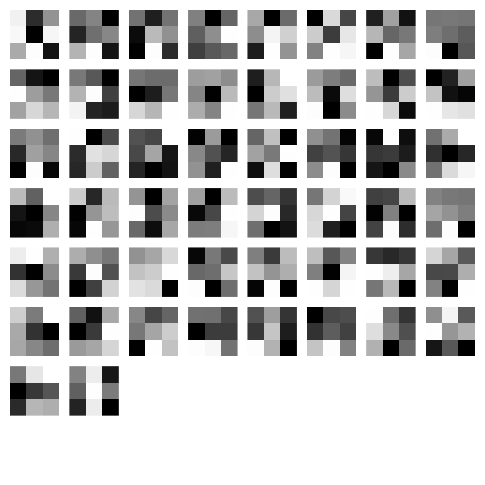

In [13]:
visualize.plot_conv_weights(cnn.layers_['conv2d1'])

In [14]:
# now transfer to svm
# stratified cross-validation
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
n_cv = 1
for train_index, val_index in sss.split(data, label):
    t1 = time.time()
    data_train, data_val = data[train_index], data[val_index]
    label_train, label_val = label[train_index], label[val_index]
    
    freq_train = itemfreq(label_train)
    print "train freq", freq_train[:,1]
    freq_val = itemfreq(label_val)
    print "val freq", freq_val[:,1]

    # pass through cnn
    extract_train = extract_features(cnn, data_train)
    extract_val = extract_features(cnn, data_val)
    clf = SVC(verbose=True, random_state=None)
    print "Training cv {} ...".format(n_cv)
    clf.fit(extract_train, label_train)
    acc = clf.score(extract_val, label_val)
    t2 = time.time()
    print acc
    print "Time took: {0:.2f} min".format((t2-t1)/60)
    print "\n"
    n_cv += 1

train freq [1890 2479 2479]
val freq [473 620 620]
Extracting ... 
Extracting ... 
Training cv 1 ...
[LibSVM]0.866900175131
Time took: 6.87 min


train freq [1890 2479 2479]
val freq [473 620 620]
Extracting ... 
Extracting ... 
Training cv 2 ...
[LibSVM]0.872737886748
Time took: 5.04 min


train freq [1890 2479 2479]
val freq [473 620 620]
Extracting ... 
Extracting ... 
Training cv 3 ...
[LibSVM]0.871570344425
Time took: 5.03 min


train freq [1890 2479 2479]
val freq [473 620 620]
Extracting ... 
Extracting ... 
Training cv 4 ...
[LibSVM]0.861646234676
Time took: 5.01 min


train freq [1890 2479 2479]
val freq [473 620 620]
Extracting ... 
Extracting ... 
Training cv 5 ...
[LibSVM]0.885580852306
Time took: 5.04 min




In [15]:
# save model
joblib.dump(clf, FILE_PATH+'model/cnn-svm-final.pkl')

['../files/model/cnn-svm-final.pkl']